# AB-тестирование(мобильное приложение). ДЗ в рамках курса Karpov "Симулятор аналитика"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from read_db.CH import Getch


In [2]:
#Собираем данные из базы
data_test = Getch('''
    select user_id,
            exp_group,
            countIf(action = 'view') as views, 
            countIf(action = 'like') as likes, 
            likes/views as CTR
from {db}.feed_actions 
where toDate(time) between '2021-11-29' and '2021-12-05' 
        and exp_group in (0,1)
group by user_id, exp_group
        ''').df

Text(0.5, 1.0, 'CTR экспериментальной выборки')

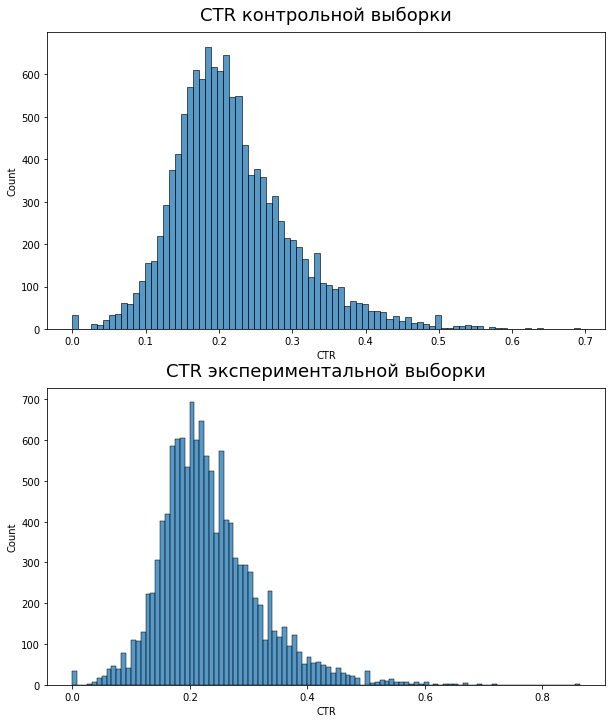

In [3]:
#Визуализируем выборки, чтобы посмотреть на распределения

plt.figure(figsize=(10, 12))
ax = plt.subplot(2,1,1)
sns.histplot(data_test.CTR.loc[data_test.exp_group == 0]) 
plt.title('CTR контрольной выборки', fontdict={'fontsize':18}, pad=12)
                   
ax = plt.subplot(2,1,2)
sns.histplot(data_test.CTR.loc[data_test.exp_group == 1])
plt.title('CTR экспериментальной выборки', fontdict={'fontsize':18}, pad=12)

In [4]:
#Применим статистические тесты
#Непараметрический тест Манна-Уитни (не требует наличия нормального распределения сравниваемых совокупностей)
stats.mannwhitneyu(data_test.CTR.loc[data_test.exp_group == 0], data_test.CTR.loc[data_test.exp_group == 1])

MannwhitneyuResult(statistic=68878160.0, pvalue=9.164668597899911e-61)

In [5]:
#Чтобы сгладить влияние пользователей, у которых мало просмотров, создадим функцию
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr =  (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [6]:
global_ctr = data_test['likes'].sum() / data_test['views'].sum()
global_ctr

0.21945457737131896

In [7]:
 data_test['smothed_CTR'] = data_test.apply(lambda row : get_smothed_ctr(row['likes'], row['views'], global_ctr, 5), axis = 1) 

Text(0.5, 1.0, 'Сглаженный CTR экспериментальной выборки')

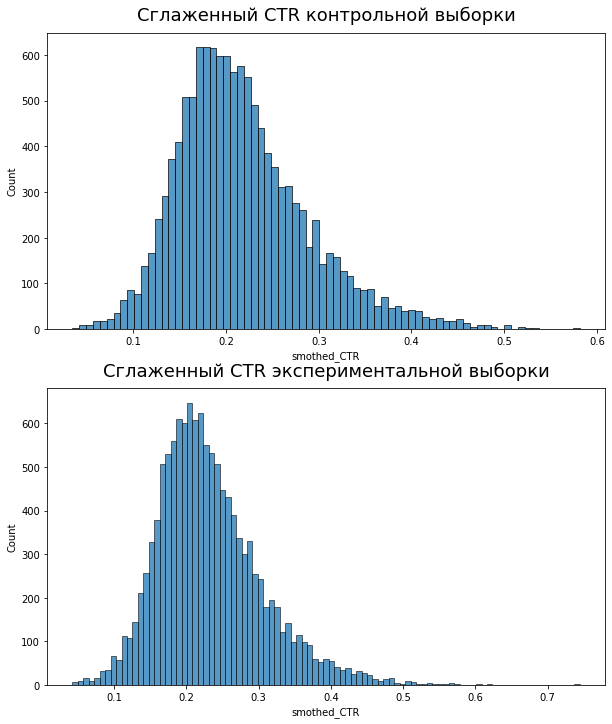

In [8]:
#Визуализируем выборки, чтобы посмотреть на измененные распределения

plt.figure(figsize=(10, 12))
ax = plt.subplot(2,1,1)
sns.histplot(data_test.smothed_CTR.loc[data_test.exp_group == 0]) 
plt.title('Сглаженный CTR контрольной выборки', fontdict={'fontsize':18}, pad=12)
                   
ax = plt.subplot(2,1,2)
sns.histplot(data_test.smothed_CTR.loc[data_test.exp_group == 1])
plt.title('Сглаженный CTR экспериментальной выборки', fontdict={'fontsize':18}, pad=12)

In [9]:
#Параметрический тест t-test (исходя из предположения, что разница выборочных средних нормально распределена)
stats.ttest_ind(data_test.CTR.loc[data_test.exp_group == 0], data_test.CTR.loc[data_test.exp_group == 1], equal_var = False)

Ttest_indResult(statistic=-14.875024726684444, pvalue=7.822946546336658e-50)

In [10]:
#Параметрический тест t-test (с учётом сглаженного CTR)
stats.ttest_ind(data_test.smothed_CTR.loc[data_test.exp_group == 0], data_test.smothed_CTR.loc[data_test.exp_group == 1], equal_var = False)

Ttest_indResult(statistic=-15.569382423548934, pvalue=2.1166936466605434e-54)

# **Вывод:**
## Значения pvalue, полученные в результате применения статистических тестов, значительно ниже заданного порога значимости (0.05), а значит есть основания отвергнуть нулевую гипотезу и признать статистическую значимость различий между CTR в рассматриваемых выборках.


In [17]:
#Проанализируем количество просмотров и лайков в выборках
print('Общие показатели контрольной группы 0:\n\tколичество просмотров = {0},\n\tколичество лайков = {1},\n\tCTR = {2}%'.format(data_test[data_test.exp_group == 0].views.sum(), \
                                        data_test[data_test.exp_group == 0].likes.sum(), round(data_test[data_test.exp_group == 0].likes.sum()/data_test[data_test.exp_group == 0].views.sum(),2) ))

print('\n\nОбщие показатели экспериментальной группы 1:\n\tколичество просмотров = {0},\n\tколичество лайков = {1},\n\tCTR = {2}%'.format(data_test[data_test.exp_group == 1].views.sum(), \
                                        data_test[data_test.exp_group == 1].likes.sum(), round(data_test[data_test.exp_group == 0].likes.sum()/data_test[data_test.exp_group == 1].views.sum(),2) ))

Общие показатели контрольной группы 0:
	количество просмотров = 934290,
	количество лайков = 197582,
	CTR = 0.21%


Общие показатели экспериментальной группы 1:
	количество просмотров = 934206,
	количество лайков = 212468,
	CTR = 0.21%


# **Вывод:**
## Количество просмотров в экспериментальной группе относительно контрольной не увеличилось, однако при этом увеличилось количество лайков, а значит есть основания раскатывать новый алгоритм на всех новых пользователей.
